In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import nibabel as nib
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import load_model
import imageio
import numpy as np
from skimage import measure
from mpl_toolkits.mplot3d.art3d import Poly3DCollection


print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.18.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [3]:
# ============================================================================
# STEP 1: ACDC DATA LOADER - LOAD REAL NIfTI DATA
# ============================================================================

class ACDCDataLoader:
    def __init__(self, data_path):
        self.data_path = data_path
        self.class_names = {
            0: 'background',
            1: 'right_ventricle', 
            2: 'myocardium',
            3: 'left_ventricle'
        }
        
    def load_acdc_data(self):
        """Load real ACDC2017 dataset from BMP files"""
        print(f"Loading ACDC data from: {self.data_path}")
        
        images = []
        masks = []
        patient_ids = []
        
        # Get images and gt folders
        images_dir = os.path.join(self.data_path, 'images')
        gt_dir = os.path.join(self.data_path, 'gt')
        
        if not os.path.exists(images_dir) or not os.path.exists(gt_dir):
            raise FileNotFoundError(f"Expected 'images' and 'gt' folders in {self.data_path}")
        
        # Get all image files (BMP format)
        image_files = sorted([f for f in os.listdir(images_dir) if f.endswith('.bmp')])
        
        print(f"Found {len(image_files)} image files")
        
        for img_file in tqdm(image_files):
            img_path = os.path.join(images_dir, img_file)
            # GT file has same name as image file
            gt_path = os.path.join(gt_dir, img_file)
            
            if os.path.exists(gt_path):
                img, mask = self._load_bmp_pair(img_path, gt_path)
                if img is not None and mask is not None:
                    images.append(img)
                    masks.append(mask)
                    patient_ids.append(os.path.splitext(img_file)[0])
        
        print(f"Loaded {len(images)} images")
        
        return np.array(images), np.array(masks), patient_ids
    
    def _load_bmp_pair(self, img_path, mask_path):
        """Load BMP image and mask, normalize image"""
        try:
            # Load BMP files using OpenCV
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            
            if img is None or mask is None:
                print(f"Failed to load {img_path} or {mask_path}")
                return None, None
            
            # Resize to 256x256 for consistency
            img = cv2.resize(img, (256, 256), interpolation=cv2.INTER_LINEAR)
            mask = cv2.resize(mask, (256, 256), interpolation=cv2.INTER_NEAREST)
            
            # Convert to float
            img = img.astype(np.float32)
            mask = mask.astype(np.uint8)
            
            # Normalize image to 0-1 range
            img_min = img.min()
            img_max = img.max()
            if img_max > img_min:
                img = (img - img_min) / (img_max - img_min)
            else:
                img = np.zeros_like(img)
            
            # ✅ FIXED: SWAPPED LABEL MAPPING FOR ACDC
            # Your BMP files have: 85=LV, 255=RV (SWAPPED!)
            unique_vals = np.unique(mask)
            
            if len(unique_vals) > 0 and unique_vals.max() > 3:
                # SWAPPED MAPPING - CORRECT FOR YOUR DATA:
                mask_converted = np.zeros_like(mask)
                mask_converted[mask == 0] = 0    # Background
                mask_converted[mask == 85] = 3   # LEFT VENTRICLE  ← SWAPPED
                mask_converted[mask == 170] = 2  # MYOCARDIUM  
                mask_converted[mask == 255] = 1  # RIGHT VENTRICLE ← SWAPPED
                mask = mask_converted
            
            # Add channel dimension to image
            img = img.reshape(256, 256, 1)
            
            return img, mask
            
        except Exception as e:
            print(f"Error loading {img_path}: {e}")
            return None, None

In [4]:

# ============================================================================
# STEP 2: LOAD DATA
# ============================================================================

ACDC_TRAIN_PATH = "/kaggle/input/acdc2017/acdc2017/train"
ACDC_VAL_PATH = "/kaggle/input/acdc2017/acdc2017/valid"
ACDC_TEST_PATH = "/kaggle/input/acdc2017/acdc2017/test"

# Check which datasets exist
datasets_to_load = []
if os.path.exists(ACDC_TRAIN_PATH):
    datasets_to_load.append(('train', ACDC_TRAIN_PATH))
if os.path.exists(ACDC_VAL_PATH):
    datasets_to_load.append(('valid', ACDC_VAL_PATH))
if os.path.exists(ACDC_TEST_PATH):
    datasets_to_load.append(('test', ACDC_TEST_PATH))

if not datasets_to_load:
    print("ERROR: ACDC data not found!")
    print("Expected structure:")
    print("  acdc2017/")
    print("  ├── train/")
    print("  │   ├── images/")
    print("  │   └── gt/")
    print("  ├── valid/")
    print("  │   ├── images/")
    print("  │   └── gt/")
    print("  └── test/")
    print("      ├── images/")
    print("      └── gt/")
else:
    # Load all available datasets (train, valid, test)
    datasets = {}
    
    for dataset_name, dataset_path in datasets_to_load:
        print(f"\n{'='*60}")
        print(f"Loading {dataset_name.upper()} dataset...")
        print(f"{'='*60}")
        
        data_loader = ACDCDataLoader(dataset_path)
        X, y, patient_ids = data_loader.load_acdc_data()
        
        datasets[dataset_name] = {
            'X': X,
            'y': y,
            'patient_ids': patient_ids
        }
        
        print(f"  {dataset_name}: {len(X)} samples loaded")
    
    # Use pre-split datasets
    X_train = datasets['train']['X'] if 'train' in datasets else None
    y_train = datasets['train']['y'] if 'train' in datasets else None
    
    X_val = datasets['valid']['X'] if 'valid' in datasets else None
    y_val = datasets['valid']['y'] if 'valid' in datasets else None
    
    X_test = datasets['test']['X'] if 'test' in datasets else None
    y_test = datasets['test']['y'] if 'test' in datasets else None
    
    if X_train is None or X_val is None or X_test is None:
        raise ValueError("Missing train, valid, or test datasets!")
    
    print(f"\n{'='*60}")
    print(f"DATA LOADED (PRE-SPLIT)")
    print(f"{'='*60}")
    print(f"Training samples: {len(X_train):,}")
    print(f"Validation samples: {len(X_val):,}")
    print(f"Test samples: {len(X_test):,}")
    print(f"Total: {len(X_train) + len(X_val) + len(X_test):,}")
    print(f"\nImage shape: {X_train.shape}, Mask shape: {y_train.shape}")
    print(f"Image range: [{X_train.min():.3f}, {X_train.max():.3f}]")
    print(f"Mask unique values: {np.unique(y_train)}")
    


Loading TRAIN dataset...
Loading ACDC data from: /kaggle/input/acdc2017/acdc2017/train
Found 1282 image files


100%|██████████| 1282/1282 [00:27<00:00, 46.25it/s]


Loaded 1282 images
  train: 1282 samples loaded

Loading VALID dataset...
Loading ACDC data from: /kaggle/input/acdc2017/acdc2017/valid
Found 172 image files


100%|██████████| 172/172 [00:03<00:00, 48.88it/s]


Loaded 172 images
  valid: 172 samples loaded

Loading TEST dataset...
Loading ACDC data from: /kaggle/input/acdc2017/acdc2017/test
Found 448 image files


100%|██████████| 448/448 [00:09<00:00, 46.90it/s]


Loaded 448 images
  test: 448 samples loaded

DATA LOADED (PRE-SPLIT)
Training samples: 1,282
Validation samples: 172
Test samples: 448
Total: 1,902

Image shape: (1282, 256, 256, 1), Mask shape: (1282, 256, 256)
Image range: [0.000, 1.000]
Mask unique values: [0 1 2 3]


In [5]:
def multi_unet_model(n_classes=4, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=1):
        inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
        s = inputs

        # Contraction path
        c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
        c1 = Dropout(0.1)(c1)
        c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
        p1 = MaxPooling2D((2, 2))(c1)

        c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
        c2 = Dropout(0.1)(c2)
        c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
        p2 = MaxPooling2D((2, 2))(c2)

        c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
        c3 = Dropout(0.2)(c3)
        c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
        p3 = MaxPooling2D((2, 2))(c3)

        c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
        c4 = Dropout(0.2)(c4)
        c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
        p4 = MaxPooling2D(pool_size=(2, 2))(c4)

        c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
        c5 = Dropout(0.3)(c5)
        c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

        # Expansive path
        u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
        u6 = concatenate([u6, c4])
        c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
        c6 = Dropout(0.2)(c6)
        c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

        u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
        u7 = concatenate([u7, c3])
        c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
        c7 = Dropout(0.2)(c7)
        c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

        u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
        u8 = concatenate([u8, c2])
        c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
        c8 = Dropout(0.1)(c8)
        c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

        u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
        u9 = concatenate([u9, c1], axis=3)
        c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
        c9 = Dropout(0.1)(c9)
        c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

        outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)

        model = Model(inputs=[inputs], outputs=[outputs])
        return model
    
print("\nBuilding U-Net model...")
model = multi_unet_model(n_classes=4, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=1)
    


Building U-Net model...


I0000 00:00:1762691154.210674      48 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1762691154.211304      48 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [6]:
# Custom Dice coefficient
def sparse_dice_coefficient(y_true, y_pred, smooth=1.0):
    y_true = tf.cast(y_true, tf.int32)
    y_true = tf.one_hot(y_true, depth=4)
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (
        tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)
    

In [7]:
model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy', sparse_dice_coefficient]
    )
    
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        160 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256, 256,  │          0 │ conv2d[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │      2,320 │ dropout[0][0]     │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128, 128,  │          0 │ conv2d_2[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │      9,248 │ dropout_1[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64, 64,    │          0 │ conv2d_4[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │     36,928 │ dropout_2[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │     73,856 │ max_pooling2d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 32, 32,    │          0 │ conv2d_6[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │    147,584 │ dropout_3[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 16, 16,    │          0 │ conv2d_7[0][0]  

 Total params: 1,940,868 (7.40 MB)

 Trainable params: 1,940,868 (7.40 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
BATCH_SIZE = 8
EPOCHS = 50

callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        verbose=1,
        min_delta=0.001,
        mode='min'
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=10,
        min_lr=1e-7,
        verbose=1,
        mode='min'
    ),
    ModelCheckpoint(
        './best_cardiac_model.h5',
        save_best_only=True,
        monitor='val_loss',
        mode='min',
        verbose=1
    ),
    tf.keras.callbacks.CSVLogger('./training_log.csv', append=True)
]


In [9]:
X_train = X_train.astype(np.float32)
X_val = X_val.astype(np.float32)
y_train = y_train.astype(np.int32)
y_val = y_val.astype(np.int32)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Steps per epoch: {len(X_train) // BATCH_SIZE}")

try:
    history = model.fit(
        X_train, y_train,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=(X_val, y_val),
        callbacks=callbacks,
        verbose=1,
        shuffle=True
    )
    print(f"\n✅ Training completed!")
except Exception as e:
    print(f"\n❌ Training failed with error: {e}")
    print("\nTroubleshooting:")
    print("1. Try reducing batch size (e.g., 4 or 2)")
    print("2. Try using CPU: Uncomment os.environ['CUDA_VISIBLE_DEVICES'] = '-1'")
    print("3. Try reducing image size or number of samples")
    print("4. Clear GPU cache: tf.keras.backend.clear_session()")
    
    # Try to clear and retry with smaller batch size
    tf.keras.backend.clear_session()
    print("\nRetrying with smaller batch size (4)...")
    BATCH_SIZE = 4
    
    history = model.fit(
        X_train, y_train,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=(X_val, y_val),
        callbacks=callbacks,
        verbose=1,
        shuffle=True
    )
    print(f"\n✅ Training completed with batch size {BATCH_SIZE}!")


Training data shape: (1282, 256, 256, 1)
Validation data shape: (172, 256, 256, 1)
Batch size: 8
Steps per epoch: 160
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 256, 256, 1))
  warnings.warn(msg)
I0000 00:00:1762691163.218367     113 service.cc:148] XLA service 0x78dbe4002700 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1762691163.219300     113 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1762691163.219321     113 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
W0000 00:00:1762691163.761630     113 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
I0000 00:00:1762691164.242245     113 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/161 ━━━━━━━━━━━━━━━━━━━━ 1:02:08 23s/step - accuracy: 0.0334 - loss: 1.5513 - sparse_dice_coefficient: 0.2185

I0000 00:00:1762691180.416189     113 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


160/161 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.4911 - loss: 0.9907 - sparse_dice_coefficient: 0.4783

W0000 00:00:1762691191.239779     114 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.4929 - loss: 0.9880 - sparse_dice_coefficient: 0.4798

W0000 00:00:1762691203.637114     114 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1762691206.346468     113 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert



Epoch 1: val_loss improved from inf to 0.39222, saving model to ./best_cardiac_model.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 51s 176ms/step - accuracy: 0.4945 - loss: 0.9853 - sparse_dice_coefficient: 0.4813 - val_accuracy: 0.9683 - val_loss: 0.3922 - val_sparse_dice_coefficient: 0.7358 - learning_rate: 1.0000e-04
Epoch 2/50
160/161 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.9636 - loss: 0.1344 - sparse_dice_coefficient: 0.9362
Epoch 2: val_loss improved from 0.39222 to 0.16389, saving model to ./best_cardiac_model.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 11s 70ms/step - accuracy: 0.9636 - loss: 0.1343 - sparse_dice_coefficient: 0.9363 - val_accuracy: 0.9666 - val_loss: 0.1639 - val_sparse_dice_coefficient: 0.8916 - learning_rate: 1.0000e-04
Epoch 3/50
160/161 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.9662 - loss: 0.1040 - sparse_dice_coefficient: 0.9500
Epoch 3: val_loss improved from 0.16389 to 0.16288, saving model to ./best_cardiac_model.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 11s 70ms/step - accuracy: 0.9663 - loss: 0.1039 - sparse_dice_coefficient: 0.9500 - val_accuracy: 0.9533 - val_loss: 0.1629 - val_sparse_dice_coefficient: 0.8954 - learning_rate: 1.0000e-04
Epoch 4/50
160/161 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9689 - loss: 0.0908 - sparse_dice_coefficient: 0.9542
Epoch 4: val_loss improved from 0.16288 to 0.10672, saving model to ./best_cardiac_model.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 12s 72ms/step - accuracy: 0.9689 - loss: 0.0908 - sparse_dice_coefficient: 0.9542 - val_accuracy: 0.9633 - val_loss: 0.1067 - val_sparse_dice_coefficient: 0.9359 - learning_rate: 1.0000e-04
Epoch 5/50
160/161 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9709 - loss: 0.0808 - sparse_dice_coefficient: 0.9595
Epoch 5: val_loss did not improve from 0.10672
161/161 ━━━━━━━━━━━━━━━━━━━━ 11s 71ms/step - accuracy: 0.9709 - loss: 0.0808 - sparse_dice_coefficient: 0.9595 - val_accuracy: 0.9583 - val_loss: 0.1180 - val_sparse_dice_coefficient: 0.9302 - learning_rate: 1.0000e-04
Epoch 6/50
160/161 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9716 - loss: 0.0748 - sparse_dice_coefficient: 0.9616
Epoch 6: val_loss did not improve from 0.10672
161/161 ━━━━━━━━━━━━━━━━━━━━ 12s 72ms/step - accuracy: 0.9716 - loss: 0.0748 - sparse_dice_coefficient: 0.9616 - val_accuracy: 0.9603 - val_loss: 0.1261 - val_sparse_dice_coefficient: 0.9244 - learning_rate: 1.0000e-04
Epoch 7

161/161 ━━━━━━━━━━━━━━━━━━━━ 12s 75ms/step - accuracy: 0.9769 - loss: 0.0599 - sparse_dice_coefficient: 0.9686 - val_accuracy: 0.9672 - val_loss: 0.0826 - val_sparse_dice_coefficient: 0.9510 - learning_rate: 1.0000e-04
Epoch 9/50
160/161 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.9826 - loss: 0.0490 - sparse_dice_coefficient: 0.9743
Epoch 9: val_loss improved from 0.08258 to 0.05841, saving model to ./best_cardiac_model.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 12s 77ms/step - accuracy: 0.9827 - loss: 0.0490 - sparse_dice_coefficient: 0.9743 - val_accuracy: 0.9782 - val_loss: 0.0584 - val_sparse_dice_coefficient: 0.9650 - learning_rate: 1.0000e-04
Epoch 10/50
160/161 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.9855 - loss: 0.0410 - sparse_dice_coefficient: 0.9782
Epoch 10: val_loss did not improve from 0.05841
161/161 ━━━━━━━━━━━━━━━━━━━━ 12s 77ms/step - accuracy: 0.9856 - loss: 0.0410 - sparse_dice_coefficient: 0.9782 - val_accuracy: 0.9650 - val_loss: 0.0829 - val_sparse_dice_coefficient: 0.9528 - learning_rate: 1.0000e-04
Epoch 11/50
160/161 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9862 - loss: 0.0386 - sparse_dice_coefficient: 0.9795
Epoch 11: val_loss improved from 0.05841 to 0.05805, saving model to ./best_cardiac_model.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 13s 79ms/step - accuracy: 0.9862 - loss: 0.0385 - sparse_dice_coefficient: 0.9795 - val_accuracy: 0.9772 - val_loss: 0.0581 - val_sparse_dice_coefficient: 0.9655 - learning_rate: 1.0000e-04
Epoch 12/50
160/161 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.9876 - loss: 0.0348 - sparse_dice_coefficient: 0.9815
Epoch 12: val_loss improved from 0.05805 to 0.05504, saving model to ./best_cardiac_model.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 13s 80ms/step - accuracy: 0.9877 - loss: 0.0348 - sparse_dice_coefficient: 0.9815 - val_accuracy: 0.9776 - val_loss: 0.0550 - val_sparse_dice_coefficient: 0.9691 - learning_rate: 1.0000e-04
Epoch 13/50
160/161 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.9887 - loss: 0.0318 - sparse_dice_coefficient: 0.9830
Epoch 13: val_loss improved from 0.05504 to 0.05112, saving model to ./best_cardiac_model.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 13s 80ms/step - accuracy: 0.9887 - loss: 0.0319 - sparse_dice_coefficient: 0.9830 - val_accuracy: 0.9798 - val_loss: 0.0511 - val_sparse_dice_coefficient: 0.9728 - learning_rate: 1.0000e-04
Epoch 14/50
160/161 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9895 - loss: 0.0291 - sparse_dice_coefficient: 0.9841
Epoch 14: val_loss improved from 0.05112 to 0.04282, saving model to ./best_cardiac_model.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 13s 79ms/step - accuracy: 0.9895 - loss: 0.0292 - sparse_dice_coefficient: 0.9841 - val_accuracy: 0.9825 - val_loss: 0.0428 - val_sparse_dice_coefficient: 0.9754 - learning_rate: 1.0000e-04
Epoch 15/50
160/161 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.9900 - loss: 0.0277 - sparse_dice_coefficient: 0.9851
Epoch 15: val_loss improved from 0.04282 to 0.04015, saving model to ./best_cardiac_model.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 13s 78ms/step - accuracy: 0.9900 - loss: 0.0277 - sparse_dice_coefficient: 0.9851 - val_accuracy: 0.9839 - val_loss: 0.0402 - val_sparse_dice_coefficient: 0.9770 - learning_rate: 1.0000e-04
Epoch 16/50
160/161 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.9888 - loss: 0.0313 - sparse_dice_coefficient: 0.9833
Epoch 16: val_loss improved from 0.04015 to 0.03993, saving model to ./best_cardiac_model.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 13s 78ms/step - accuracy: 0.9888 - loss: 0.0313 - sparse_dice_coefficient: 0.9833 - val_accuracy: 0.9844 - val_loss: 0.0399 - val_sparse_dice_coefficient: 0.9780 - learning_rate: 1.0000e-04
Epoch 17/50
160/161 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9912 - loss: 0.0243 - sparse_dice_coefficient: 0.9867
Epoch 17: val_loss improved from 0.03993 to 0.03895, saving model to ./best_cardiac_model.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 13s 79ms/step - accuracy: 0.9912 - loss: 0.0243 - sparse_dice_coefficient: 0.9867 - val_accuracy: 0.9840 - val_loss: 0.0389 - val_sparse_dice_coefficient: 0.9792 - learning_rate: 1.0000e-04
Epoch 18/50
160/161 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9915 - loss: 0.0233 - sparse_dice_coefficient: 0.9872
Epoch 18: val_loss improved from 0.03895 to 0.02694, saving model to ./best_cardiac_model.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 13s 79ms/step - accuracy: 0.9915 - loss: 0.0233 - sparse_dice_coefficient: 0.9872 - val_accuracy: 0.9904 - val_loss: 0.0269 - val_sparse_dice_coefficient: 0.9858 - learning_rate: 1.0000e-04
Epoch 19/50
160/161 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9908 - loss: 0.0255 - sparse_dice_coefficient: 0.9863
Epoch 19: val_loss did not improve from 0.02694
161/161 ━━━━━━━━━━━━━━━━━━━━ 13s 78ms/step - accuracy: 0.9908 - loss: 0.0255 - sparse_dice_coefficient: 0.9864 - val_accuracy: 0.9873 - val_loss: 0.0325 - val_sparse_dice_coefficient: 0.9823 - learning_rate: 1.0000e-04
Epoch 20/50
160/161 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9922 - loss: 0.0211 - sparse_dice_coefficient: 0.9885
Epoch 20: val_loss did not improve from 0.02694
161/161 ━━━━━━━━━━━━━━━━━━━━ 12s 78ms/step - accuracy: 0.9922 - loss: 0.0211 - sparse_dice_coefficient: 0.9885 - val_accuracy: 0.9869 - val_loss: 0.0340 - val_sparse_dice_coefficient: 0.9830 - learning_rate: 1.0000e-04
Epo

161/161 ━━━━━━━━━━━━━━━━━━━━ 13s 79ms/step - accuracy: 0.9919 - loss: 0.0219 - sparse_dice_coefficient: 0.9882 - val_accuracy: 0.9895 - val_loss: 0.0263 - val_sparse_dice_coefficient: 0.9862 - learning_rate: 1.0000e-04
Epoch 22/50
160/161 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9926 - loss: 0.0199 - sparse_dice_coefficient: 0.9890
Epoch 22: val_loss did not improve from 0.02629
161/161 ━━━━━━━━━━━━━━━━━━━━ 12s 77ms/step - accuracy: 0.9926 - loss: 0.0199 - sparse_dice_coefficient: 0.9890 - val_accuracy: 0.9880 - val_loss: 0.0298 - val_sparse_dice_coefficient: 0.9838 - learning_rate: 1.0000e-04
Epoch 23/50
160/161 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9926 - loss: 0.0196 - sparse_dice_coefficient: 0.9890
Epoch 23: val_loss did not improve from 0.02629
161/161 ━━━━━━━━━━━━━━━━━━━━ 12s 77ms/step - accuracy: 0.9926 - loss: 0.0196 - sparse_dice_coefficient: 0.9890 - val_accuracy: 0.9885 - val_loss: 0.0291 - val_sparse_dice_coefficient: 0.9848 - learning_rate: 1.0000e-04
Epo

161/161 ━━━━━━━━━━━━━━━━━━━━ 13s 78ms/step - accuracy: 0.9930 - loss: 0.0187 - sparse_dice_coefficient: 0.9898 - val_accuracy: 0.9908 - val_loss: 0.0238 - val_sparse_dice_coefficient: 0.9874 - learning_rate: 1.0000e-04
Epoch 25/50
160/161 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9933 - loss: 0.0177 - sparse_dice_coefficient: 0.9902
Epoch 25: val_loss did not improve from 0.02380
161/161 ━━━━━━━━━━━━━━━━━━━━ 12s 77ms/step - accuracy: 0.9933 - loss: 0.0177 - sparse_dice_coefficient: 0.9902 - val_accuracy: 0.9896 - val_loss: 0.0265 - val_sparse_dice_coefficient: 0.9863 - learning_rate: 1.0000e-04
Epoch 26/50
160/161 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9936 - loss: 0.0168 - sparse_dice_coefficient: 0.9906
Epoch 26: val_loss did not improve from 0.02380
161/161 ━━━━━━━━━━━━━━━━━━━━ 12s 77ms/step - accuracy: 0.9936 - loss: 0.0168 - sparse_dice_coefficient: 0.9906 - val_accuracy: 0.9901 - val_loss: 0.0262 - val_sparse_dice_coefficient: 0.9864 - learning_rate: 1.0000e-04
Epo

161/161 ━━━━━━━━━━━━━━━━━━━━ 13s 79ms/step - accuracy: 0.9940 - loss: 0.0152 - sparse_dice_coefficient: 0.9914 - val_accuracy: 0.9912 - val_loss: 0.0235 - val_sparse_dice_coefficient: 0.9885 - learning_rate: 1.0000e-04
Epoch 31/50
160/161 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9941 - loss: 0.0151 - sparse_dice_coefficient: 0.9915
Epoch 31: val_loss did not improve from 0.02349
161/161 ━━━━━━━━━━━━━━━━━━━━ 12s 78ms/step - accuracy: 0.9941 - loss: 0.0151 - sparse_dice_coefficient: 0.9915 - val_accuracy: 0.9887 - val_loss: 0.0294 - val_sparse_dice_coefficient: 0.9859 - learning_rate: 1.0000e-04
Epoch 32/50
160/161 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9945 - loss: 0.0141 - sparse_dice_coefficient: 0.9920
Epoch 32: val_loss improved from 0.02349 to 0.02281, saving model to ./best_cardiac_model.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 13s 78ms/step - accuracy: 0.9945 - loss: 0.0141 - sparse_dice_coefficient: 0.9920 - val_accuracy: 0.9920 - val_loss: 0.0228 - val_sparse_dice_coefficient: 0.9899 - learning_rate: 1.0000e-04
Epoch 33/50
160/161 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9944 - loss: 0.0141 - sparse_dice_coefficient: 0.9920
Epoch 33: val_loss did not improve from 0.02281
161/161 ━━━━━━━━━━━━━━━━━━━━ 12s 77ms/step - accuracy: 0.9944 - loss: 0.0141 - sparse_dice_coefficient: 0.9920 - val_accuracy: 0.9914 - val_loss: 0.0241 - val_sparse_dice_coefficient: 0.9890 - learning_rate: 1.0000e-04
Epoch 34/50
160/161 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9946 - loss: 0.0137 - sparse_dice_coefficient: 0.9922
Epoch 34: val_loss did not improve from 0.02281
161/161 ━━━━━━━━━━━━━━━━━━━━ 12s 77ms/step - accuracy: 0.9946 - loss: 0.0137 - sparse_dice_coefficient: 0.9922 - val_accuracy: 0.9901 - val_loss: 0.0262 - val_sparse_dice_coefficient: 0.9874 - learning_rate: 1.0000e-04
Epo

161/161 ━━━━━━━━━━━━━━━━━━━━ 13s 79ms/step - accuracy: 0.9950 - loss: 0.0124 - sparse_dice_coefficient: 0.9929 - val_accuracy: 0.9925 - val_loss: 0.0216 - val_sparse_dice_coefficient: 0.9906 - learning_rate: 1.0000e-04
Epoch 39/50
160/161 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9949 - loss: 0.0126 - sparse_dice_coefficient: 0.9928
Epoch 39: val_loss did not improve from 0.02159
161/161 ━━━━━━━━━━━━━━━━━━━━ 12s 77ms/step - accuracy: 0.9949 - loss: 0.0126 - sparse_dice_coefficient: 0.9928 - val_accuracy: 0.9903 - val_loss: 0.0266 - val_sparse_dice_coefficient: 0.9878 - learning_rate: 1.0000e-04
Epoch 40/50
160/161 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9948 - loss: 0.0131 - sparse_dice_coefficient: 0.9925
Epoch 40: val_loss did not improve from 0.02159
161/161 ━━━━━━━━━━━━━━━━━━━━ 12s 77ms/step - accuracy: 0.9948 - loss: 0.0131 - sparse_dice_coefficient: 0.9925 - val_accuracy: 0.9921 - val_loss: 0.0226 - val_sparse_dice_coefficient: 0.9900 - learning_rate: 1.0000e-04
Epo

161/161 ━━━━━━━━━━━━━━━━━━━━ 13s 79ms/step - accuracy: 0.9951 - loss: 0.0120 - sparse_dice_coefficient: 0.9930 - val_accuracy: 0.9931 - val_loss: 0.0200 - val_sparse_dice_coefficient: 0.9912 - learning_rate: 1.0000e-04
Epoch 42/50
160/161 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9952 - loss: 0.0119 - sparse_dice_coefficient: 0.9931
Epoch 42: val_loss did not improve from 0.02000
161/161 ━━━━━━━━━━━━━━━━━━━━ 12s 77ms/step - accuracy: 0.9952 - loss: 0.0119 - sparse_dice_coefficient: 0.9931 - val_accuracy: 0.9916 - val_loss: 0.0237 - val_sparse_dice_coefficient: 0.9896 - learning_rate: 1.0000e-04
Epoch 43/50
160/161 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9954 - loss: 0.0113 - sparse_dice_coefficient: 0.9934
Epoch 43: val_loss did not improve from 0.02000
161/161 ━━━━━━━━━━━━━━━━━━━━ 12s 77ms/step - accuracy: 0.9954 - loss: 0.0113 - sparse_dice_coefficient: 0.9934 - val_accuracy: 0.9929 - val_loss: 0.0206 - val_sparse_dice_coefficient: 0.9910 - learning_rate: 1.0000e-04
Epo

161/161 ━━━━━━━━━━━━━━━━━━━━ 13s 78ms/step - accuracy: 0.9953 - loss: 0.0117 - sparse_dice_coefficient: 0.9932 - val_accuracy: 0.9932 - val_loss: 0.0194 - val_sparse_dice_coefficient: 0.9913 - learning_rate: 1.0000e-04
Epoch 47/50
160/161 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9954 - loss: 0.0113 - sparse_dice_coefficient: 0.9934
Epoch 47: val_loss did not improve from 0.01938
161/161 ━━━━━━━━━━━━━━━━━━━━ 12s 77ms/step - accuracy: 0.9954 - loss: 0.0113 - sparse_dice_coefficient: 0.9934 - val_accuracy: 0.9907 - val_loss: 0.0266 - val_sparse_dice_coefficient: 0.9886 - learning_rate: 1.0000e-04
Epoch 48/50
160/161 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9952 - loss: 0.0117 - sparse_dice_coefficient: 0.9933
Epoch 48: val_loss did not improve from 0.01938
161/161 ━━━━━━━━━━━━━━━━━━━━ 12s 77ms/step - accuracy: 0.9952 - loss: 0.0117 - sparse_dice_coefficient: 0.9933 - val_accuracy: 0.9927 - val_loss: 0.0205 - val_sparse_dice_coefficient: 0.9911 - learning_rate: 1.0000e-04
Epo

161/161 ━━━━━━━━━━━━━━━━━━━━ 13s 78ms/step - accuracy: 0.9957 - loss: 0.0105 - sparse_dice_coefficient: 0.9939 - val_accuracy: 0.9937 - val_loss: 0.0181 - val_sparse_dice_coefficient: 0.9922 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 50.

✅ Training completed!


In [10]:
X_test = X_test.astype(np.float32)
y_test = y_test.astype(np.int32)

# Load best model
best_model = tf.keras.models.load_model('./best_cardiac_model.h5', 
                                        custom_objects={'sparse_dice_coefficient': sparse_dice_coefficient})

test_loss, test_accuracy, test_dice = best_model.evaluate(X_test, y_test, verbose=1)

print(f"\n" + "="*60)
print("📈 TEST SET RESULTS (Real ACDC Data)")
print("="*60)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Dice Coefficient: {test_dice:.4f}")

14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 76ms/step - accuracy: 0.9891 - loss: 0.0383 - sparse_dice_coefficient: 0.9871

📈 TEST SET RESULTS (Real ACDC Data)
Test Loss: 0.0349
Test Accuracy: 0.9895
Test Dice Coefficient: 0.9876


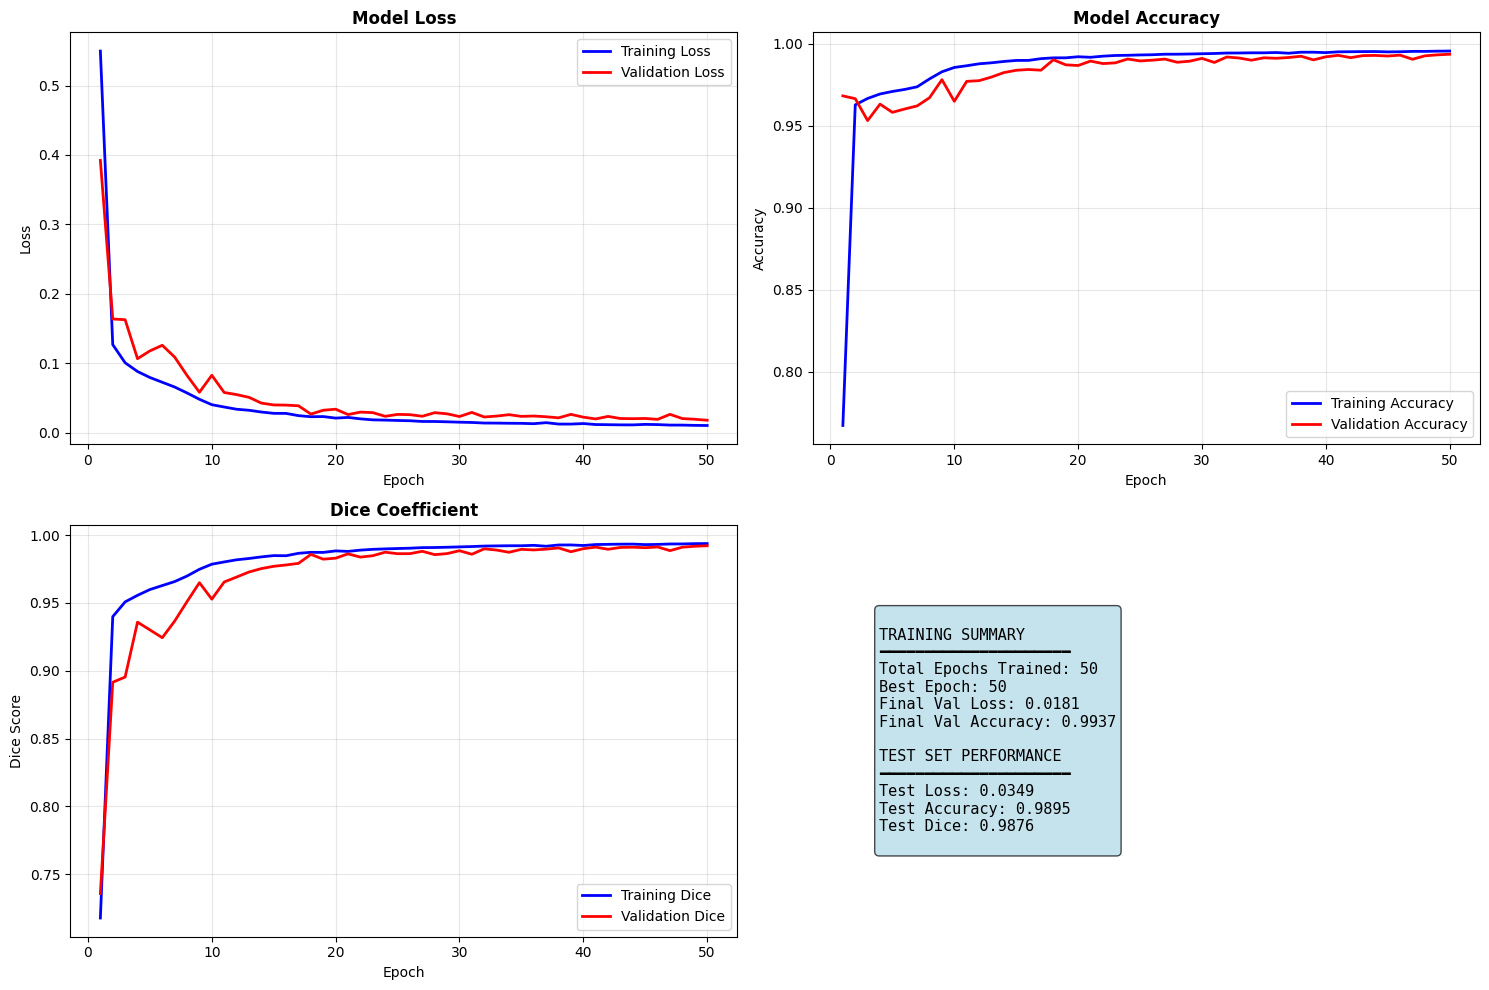

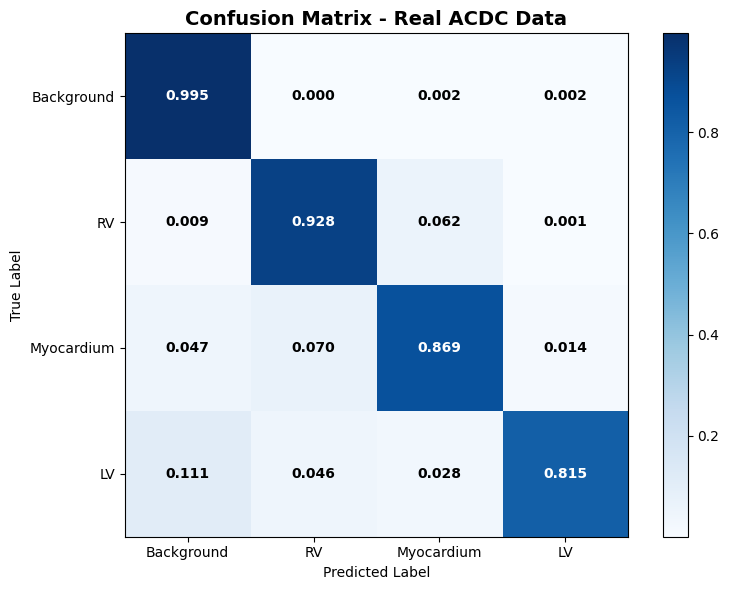

In [11]:
 
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

epochs_range = range(1, len(history.history['loss']) + 1)

# Loss
axes[0, 0].plot(epochs_range, history.history['loss'], 'b-', label='Training Loss', linewidth=2)
axes[0, 0].plot(epochs_range, history.history['val_loss'], 'r-', label='Validation Loss', linewidth=2)
axes[0, 0].set_title('Model Loss', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Accuracy
axes[0, 1].plot(epochs_range, history.history['accuracy'], 'b-', label='Training Accuracy', linewidth=2)
axes[0, 1].plot(epochs_range, history.history['val_accuracy'], 'r-', label='Validation Accuracy', linewidth=2)
axes[0, 1].set_title('Model Accuracy', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Dice Coefficient
axes[1, 0].plot(epochs_range, history.history['sparse_dice_coefficient'], 'b-', 
                label='Training Dice', linewidth=2)
axes[1, 0].plot(epochs_range, history.history['val_sparse_dice_coefficient'], 'r-', 
                label='Validation Dice', linewidth=2)
axes[1, 0].set_title('Dice Coefficient', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Dice Score')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Training summary
axes[1, 1].axis('off')
summary_text = f"""
TRAINING SUMMARY
━━━━━━━━━━━━━━━━━━━━━
Total Epochs Trained: {len(epochs_range)}
Best Epoch: {np.argmin(history.history['val_loss']) + 1}
Final Val Loss: {history.history['val_loss'][-1]:.4f}
Final Val Accuracy: {history.history['val_accuracy'][-1]:.4f}

TEST SET PERFORMANCE
━━━━━━━━━━━━━━━━━━━━━
Test Loss: {test_loss:.4f}
Test Accuracy: {test_accuracy:.4f}
Test Dice: {test_dice:.4f}
"""
axes[1, 1].text(0.1, 0.5, summary_text, fontsize=11, family='monospace',
                bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.7),
                verticalalignment='center')

plt.tight_layout()
plt.show()

# ========================================================================
# STEP 10: CONFUSION MATRIX
# ========================================================================

y_pred_probs = best_model.predict(X_test, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=-1)

y_true_flat = y_test.flatten()
y_pred_flat = y_pred.flatten()

cm = confusion_matrix(y_true_flat, y_pred_flat)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

class_names = ['Background', 'RV', 'Myocardium', 'LV']

plt.figure(figsize=(8, 6))
im = plt.imshow(cm_normalized, interpolation='nearest', cmap='Blues')
plt.title('Confusion Matrix - Real ACDC Data', fontsize=14, fontweight='bold')
plt.colorbar(im)

thresh = cm_normalized.max() / 2.
for i in range(cm_normalized.shape[0]):
    for j in range(cm_normalized.shape[1]):
        plt.text(j, i, f'{cm_normalized[i, j]:.3f}',
                horizontalalignment="center",
                verticalalignment="center",
                color="white" if cm_normalized[i, j] > thresh else "black",
                fontweight='bold')

plt.xticks(range(len(class_names)), class_names)
plt.yticks(range(len(class_names)), class_names)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

In [12]:
# PER-CLASS METRICS
    
print("\n" + "="*60)
print("📊 PER-CLASS METRICS")
print("="*60)
print(classification_report(y_true_flat, y_pred_flat, 
                            target_names=class_names, digits=4))

    


📊 PER-CLASS METRICS
              precision    recall  f1-score   support

  Background     0.9969    0.9955    0.9962  28102089
          RV     0.8301    0.9278    0.8762    315588
  Myocardium     0.7204    0.8695    0.7879    306982
          LV     0.9021    0.8150    0.8564    635469

    accuracy                         0.9895  29360128
   macro avg     0.8624    0.9019    0.8792  29360128
weighted avg     0.9901    0.9895    0.9897  29360128



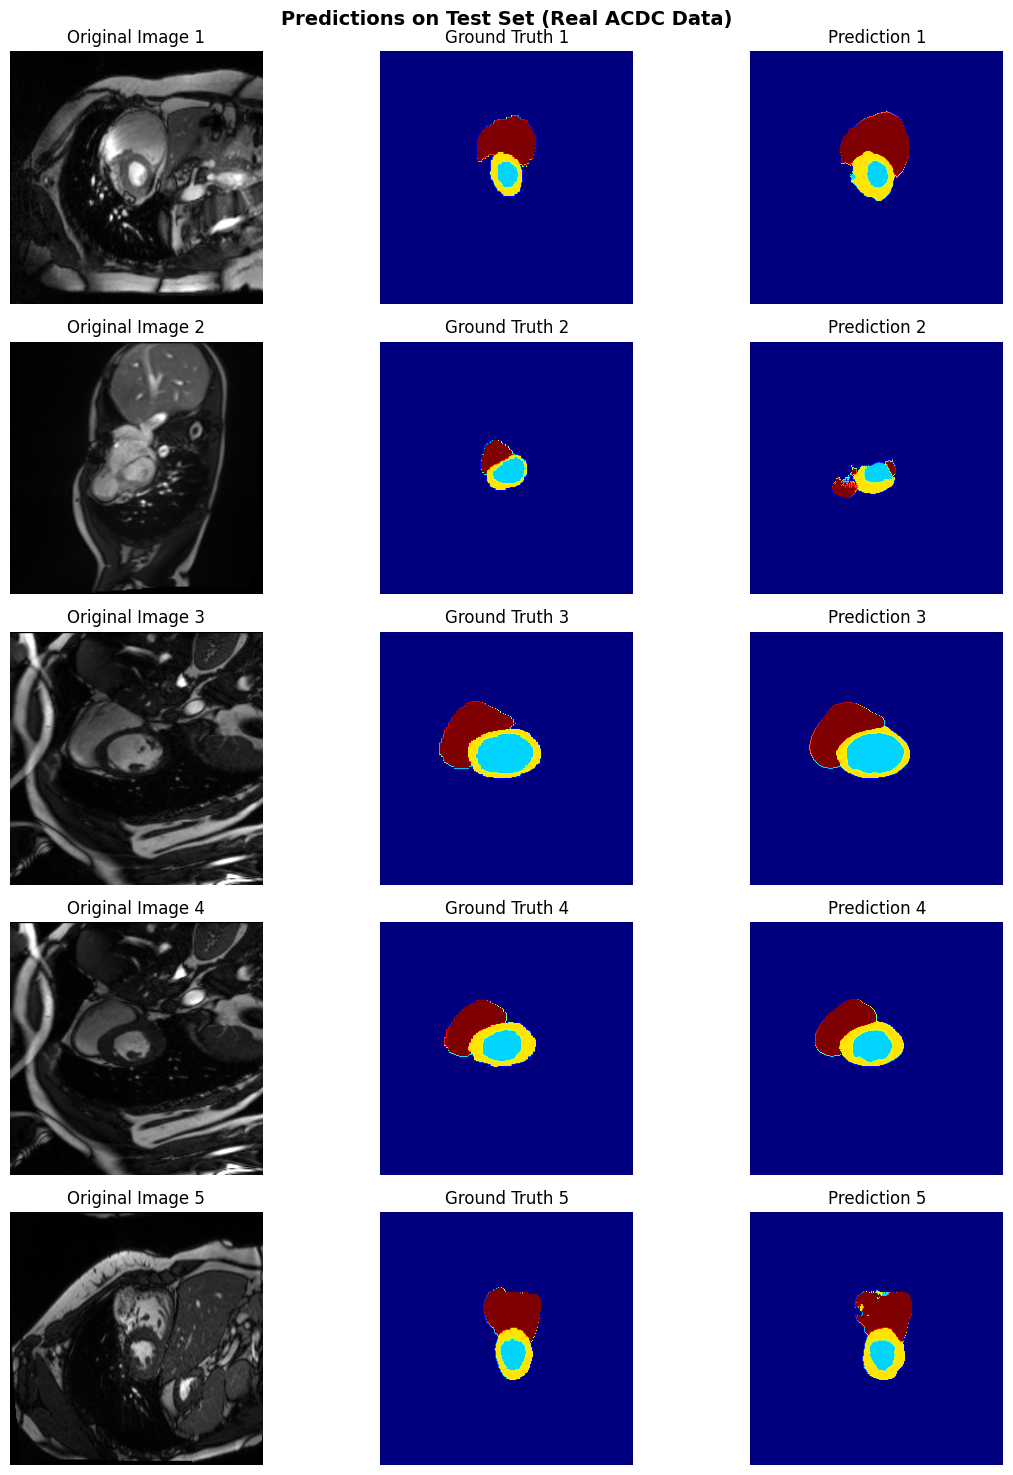


✅ TRAINING COMPLETE - REAL ACDC DATA
Model saved as: ./best_cardiac_model.h5
Training log saved as: ./training_log.csv


In [13]:
fig, axes = plt.subplots(5, 3, figsize=(12, 15))
fig.suptitle('Predictions on Test Set (Real ACDC Data)', fontweight='bold', fontsize=14)

test_indices = np.random.choice(len(X_test), 5, replace=False)

for idx, test_idx in enumerate(test_indices):
    # Original image
    axes[idx, 0].imshow(X_test[test_idx].squeeze(), cmap='gray')
    axes[idx, 0].set_title(f'Original Image {idx+1}')
    axes[idx, 0].axis('off')
    
    # Ground truth mask
    axes[idx, 1].imshow(y_test[test_idx], cmap='jet')
    axes[idx, 1].set_title(f'Ground Truth {idx+1}')
    axes[idx, 1].axis('off')
    
    # Predicted mask
    pred_mask = y_pred[test_indices[idx]]
    axes[idx, 2].imshow(pred_mask, cmap='jet')
    axes[idx, 2].set_title(f'Prediction {idx+1}')
    axes[idx, 2].axis('off')

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("✅ TRAINING COMPLETE - REAL ACDC DATA")
print("="*60)
print("Model saved as: ./best_cardiac_model.h5")
print("Training log saved as: ./training_log.csv")

In [14]:
# Ensure path exists
out_dir = "/kaggle/working/predicted_masks"
os.makedirs(out_dir, exist_ok=True)

# Use the already-loaded best_model if present, otherwise load it explicitly
best_model = load_model('/kaggle/working/best_cardiac_model.h5',
                            custom_objects={'sparse_dice_coefficient': sparse_dice_coefficient})

# 1) Predict on X_test (may take some time)
print("Predicting on X_test ...")
pred_probs = best_model.predict(X_test, verbose=1)  # shape: (N, H, W, classes)

# 2) Convert to integer labels
pred_labels = np.argmax(pred_probs, axis=-1).astype(np.uint8)  # shape: (N, H, W)

# 3) Save predicted labels as both .npy (full arrays) and per-slice PNGs for quick use
np.save(os.path.join(out_dir, "pred_labels.npy"), pred_labels)
print(f"Saved full predictions to {os.path.join(out_dir, 'pred_labels.npy')}")

# Save per-slice PNGs (jet colormap)
for i in range(pred_labels.shape[0]):
    fname = os.path.join(out_dir, f"pred_mask_{i:04d}.png")
    # scale colormap automatically by imageio; using imageio will save integer labels as colormap indices
    imageio.imwrite(fname, pred_labels[i])
# Also save some ground-truth for quick comparison
np.save(os.path.join(out_dir, "true_labels.npy"), y_test)
for i in range(y_test.shape[0]):
    imageio.imwrite(os.path.join(out_dir, f"true_mask_{i:04d}.png"), y_test[i].astype(np.uint8))

print(f"Saved {pred_labels.shape[0]} predicted PNG masks and ground-truth masks into {out_dir}")

Predicting on X_test ...
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step
Saved full predictions to /kaggle/working/predicted_masks/pred_labels.npy
Saved 448 predicted PNG masks and ground-truth masks into /kaggle/working/predicted_masks


In [16]:
def correct_heart_anatomy(pred_masks_path):
    pred_masks = np.load(pred_masks_path)
    corrected_masks = pred_masks.copy()
    
    for i in range(len(pred_masks)):
        # Get structures for this slice
        lv_slice = (pred_masks[i] == 3)
        myo_slice = (pred_masks[i] == 2)
        rv_slice = (pred_masks[i] == 1)
        
        # Only process slices with substantial LV
        if np.sum(lv_slice) > 100:
            from scipy import ndimage
            
            # Remove all myocardium and add it only around LV
            corrected_masks[i][corrected_masks[i] == 2] = 0  # Remove all myocardium
            
            # Add myocardium around LV only
            lv_dilated = ndimage.binary_dilation(lv_slice, structure=np.ones((5,5)))
            myocardium_ring = lv_dilated & ~lv_slice
            
            # Simple RV exclusion - just don't put myocardium where RV is
            myocardium_ring = myocardium_ring & ~rv_slice
            
            # Apply the myocardium
            corrected_masks[i][myocardium_ring] = 2
    
    # Save back to basics corrected masks
    np.save('/kaggle/working/predicted_masks/correct_pred_labels.npy', corrected_masks)
    print("corrected predictions saved!")
    
    return corrected_masks

# Apply back to basics fix
basics_corrected = correct_heart_anatomy('/kaggle/working/predicted_masks/pred_labels.npy')

corrected predictions saved!


3D HEART VISUALIZATION & RESULTS


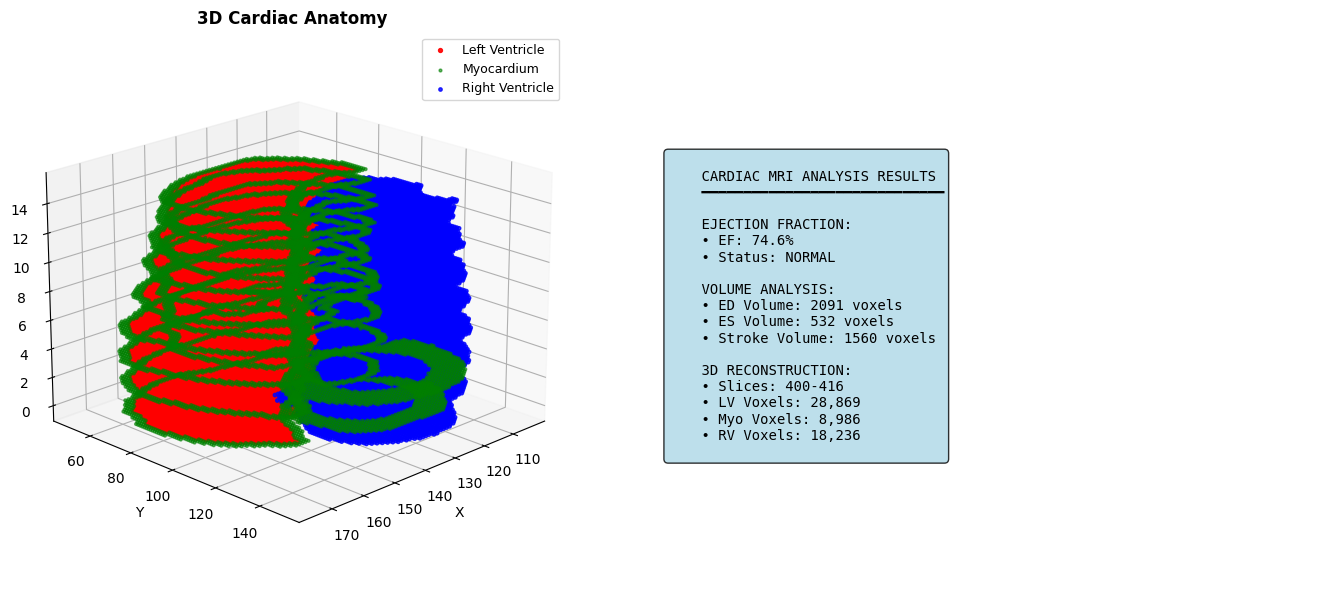


CLINICAL SUMMARY:
• Ejection Fraction: 74.6%
• Cardiac Function: NORMAL
• Anatomical Ratio: RV/LV = 0.63x
• Myocardium Position: Mainly around LV


In [21]:
# ============================================================================
# 3D VISUALIZATION WITH RESULTS
# ============================================================================

def heart_3d_with_results():
    """
    3D visualization with clinical results display
    """
    corrected_masks = np.load('/kaggle/working/predicted_masks/correct_pred_labels.npy')
    
    print("3D HEART VISUALIZATION & RESULTS")
    print("="*50)
    
    start_slice, end_slice = 400, 416
    
    patient_lv = (corrected_masks[start_slice:end_slice] == 3).astype(np.uint8)
    patient_myo = (corrected_masks[start_slice:end_slice] == 2).astype(np.uint8)
    patient_rv = (corrected_masks[start_slice:end_slice] == 1).astype(np.uint8)
    
    # Calculate clinical metrics
    lv_mask = (corrected_masks == 3).astype(np.uint8)
    slice_volumes = np.sum(lv_mask, axis=(1, 2))
    non_zero_volumes = slice_volumes[slice_volumes > 0]
    ed_volume = np.percentile(non_zero_volumes, 75)
    es_volume = np.percentile(non_zero_volumes, 25)
    EF = ((ed_volume - es_volume) / ed_volume) * 100
    
    # Calculate overlaps for anatomy assessment
    lv_myo_overlap = np.sum((patient_lv > 0) & (patient_myo > 0))
    rv_myo_overlap = np.sum((patient_rv > 0) & (patient_myo > 0))
    
    fig = plt.figure(figsize=(14, 6))
    
    # 3D Plot
    ax1 = fig.add_subplot(1, 2, 1, projection='3d')
    ax1.set_title('3D Cardiac Anatomy', fontweight='bold', fontsize=12)
    
    # Plot structures
    z, y, x = np.where(patient_lv > 0)
    ax1.scatter(x, y, z, c='red', alpha=0.9, s=8, label='Left Ventricle')
    
    z, y, x = np.where(patient_myo > 0)
    ax1.scatter(x, y, z, c='green', alpha=0.6, s=4, label='Myocardium')
    
    z, y, x = np.where(patient_rv > 0)
    ax1.scatter(x, y, z, c='blue', alpha=0.8, s=6, label='Right Ventricle')
    
    ax1.legend(fontsize=9)
    ax1.view_init(elev=20, azim=45)
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_zlabel('Slice')
    
    # Results panel
    ax2 = fig.add_subplot(1, 2, 2)
    ax2.axis('off')
    
    results_text = f"""
    CARDIAC MRI ANALYSIS RESULTS
    ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
    
    EJECTION FRACTION:
    • EF: {EF:.1f}%
    • Status: {'NORMAL' if EF >= 55 else 'REDUCED'}
    
    VOLUME ANALYSIS:
    • ED Volume: {ed_volume:.0f} voxels
    • ES Volume: {es_volume:.0f} voxels
    • Stroke Volume: {ed_volume-es_volume:.0f} voxels
    
    3D RECONSTRUCTION:
    • Slices: {start_slice}-{end_slice}
    • LV Voxels: {np.sum(patient_lv):,}
    • Myo Voxels: {np.sum(patient_myo):,}
    • RV Voxels: {np.sum(patient_rv):,}
    """
    
    ax2.text(0.05, 0.5, results_text, fontsize=10, family='monospace',
            bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8),
            verticalalignment='center')
    
    plt.tight_layout()
    plt.show()
    
    # Print additional analysis
    print(f"\nCLINICAL SUMMARY:")
    print(f"• Ejection Fraction: {EF:.1f}%")
    print(f"• Cardiac Function: {'NORMAL' if EF >= 55 else 'REDUCED'}")
    print(f"• Anatomical Ratio: RV/LV = {np.sum(patient_rv)/np.sum(patient_lv):.2f}x")
    print(f"• Myocardium Position: Mainly around LV")

# Run final visualization with results
heart_3d_with_results()